In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import serial
import io
from IPython import display
from IPython.display import clear_output
import time
from scipy.interpolate import griddata
import matplotlib.animation as animation

In [3]:
def unwrap_positions(d):
    x = [point[0] for point in positions.values()]
    y = [point[1] for point in positions.values()]
    identifiers = [point for point in positions.keys()]
    return x, y, identifiers

### Sensor Positions

In [4]:
positions = {'0x40':[46, 65], '0x43':[45, 87], '0x50':[14, 3], '0x52':[46, 3], '0x53':[12, 65], '0x58':[15, 87], '0x5A':[30, 0], '0x5B':[10, 28], '0x5D':[60, 58], '0x5E':[30, 84], '0x5F':[30, 55], '0x60':[30, 25], '0x61':[50, 28], '0x63':[0, 58]}
x, y, identifiers = unwrap_positions(positions)

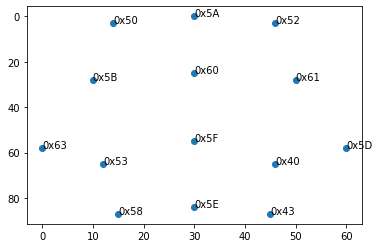

In [5]:
plt.scatter(x, y)
for i in range(0, len(x)):
    plt.annotate(identifiers[i], (x[i], y[i]))
    
plt.gca().invert_yaxis()
plt.show()

### Calibratrion

In [6]:
ser = serial.Serial() 
ser.baudrate = 115200
ser.port = '/dev/ttyS3' #replace with com port of windows machine if not running on Linux e.g. 'COM3'
ser.timeout = 0.1
ser.open()

calibrationReadings = {}

sio = io.TextIOWrapper(io.BufferedRWPair(ser, ser))
for i in range(1, 100):
    dataRead = sio.readline()

    if (dataRead.startswith('[[0x40')):
        dataRead = dataRead.replace("[[", "[").replace("]]", "]").replace("[", "", 1).split("], [")
        dataRead[len(dataRead) - 1] = dataRead[len(dataRead) - 1].replace("]\n", "")
        
        for i in range(0, len(dataRead)):
            address, value = dataRead[i].replace(" ", "").split(",")
            
            if (address in calibrationReadings):
                calibrationReadings[address].append(float(value.replace(".00", "")))
            else:
                calibrationReadings[address] = []
                calibrationReadings[address].append(float(value.replace(".00", "")))

for i in range(0, len(identifiers)):
    calibrationReadings[identifiers[i]] = sum(calibrationReadings[identifiers[i]]) / len(calibrationReadings[identifiers[i]])


max_value = max(list(calibrationReadings.values()))

calibration_offsets = {}

for i in range(0, len(identifiers)):
    calibration_offsets[identifiers[i]] = max_value - calibrationReadings[identifiers[i]]

### Visualization

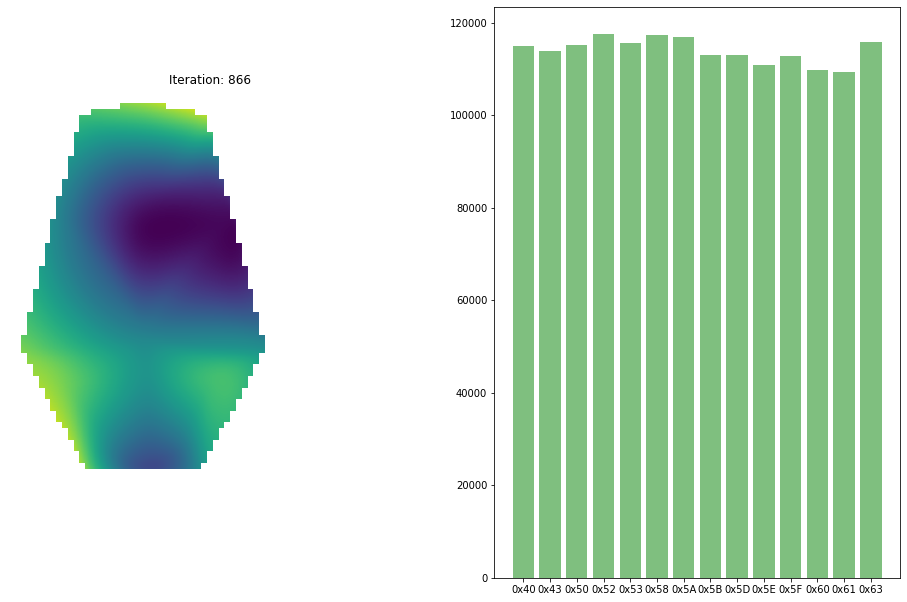

In [ ]:
fig = plt.figure()
fig.set_size_inches(16, 10.5)

ax = fig.add_subplot(1, 2, 1)
ax_bars = fig.add_subplot(1, 2, 2)

def animate_heatmap(voc, i, n=70): 
    grid_x, grid_y = np.mgrid[0:90:complex(0, n), 0:90:complex(0, n)]
    grid = griddata((y, x), voc, xi=(grid_x.flatten(), grid_y.flatten()), method='cubic')
    grid = np.array(np.array_split(grid, n))
    ax.clear()
    ax.axis('off')
    ax.set_title('Iteration: ' + str(i))
    ax.imshow(grid, interpolation='gaussian', aspect='equal')

    ax_bars.clear()
    ax_bars.bar(identifiers, voc, align='center', alpha=0.5, color='green')

    display.display(fig)

if (not ser.isOpen()):
    ser.open()

counter = 0
ser.flushInput()
sio.flush()

while (True):  # Or: while ser.inWaiting():
    vocReading = sio.readline()
    
    if (vocReading.startswith('[[0x40')):
        counter += 1
        try:
            vocReading = vocReading.replace("[[", "[").replace("]]", "]").replace("[", "", 1).split("], [")
        except:
            continue
            
        vocReading[len(vocReading) - 1] = vocReading[len(vocReading) - 1].replace("]\n", "")
        
        for j in range(0, len(vocReading)):
            try:
                address, value = vocReading[j].replace(" ", "").split(",")
            except:
                continue
            #print(vocReading)
            vocReading[j] = 1000000 - (float(value) + calibration_offsets[address])
        
        voc = vocReading
        clear_output(True)
        
        try:
            animate_heatmap(voc, counter)
        except:
            continue

In [1]:
ser.close()

NameError: name 'ser' is not defined